<a href="https://colab.research.google.com/github/busydong/Mystock/blob/main/Stock_trading_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/VivekPa/AIAlpha.git

Cloning into 'AIAlpha'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 13.53 MiB | 16.31 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [3]:
!pip install alpha_vantage

In [4]:
# !python /content/AIAlpha/run.py

In [5]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import Holt

# Importing the libraries for LTSM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error


import sys
sys.path.append('/content/AIAlpha')
sys.path.append('/content')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

ts = TimeSeries(key='T94ZYXCQNLY7H8B3')

def load_and_process(symbol, interval):
  """
      Load time series data of symbol, with interval, after 2010
      convert it to data frame, and reverse the order, rename the column names
  """
  if interval == 'daily':
    data, _ = ts.get_daily_adjusted(symbol,'full')
    data = pd.DataFrame(data).T[::-1]['2010':]
    data.columns = ['open','high','low','close','adj_close','volume','div_amt','split_coef']
    data= data.astype(float)
    data.index = pd.to_datetime(data.index)
    return data


def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
  """
      Plot time series, its ACF and PACF, calculate Dickey–Fuller test
      
      y - timeseries
      lags - how many lags to include in ACF, PACF calculation
  """
  if not isinstance(y, pd.Series):
      y = pd.Series(y)
      
  with plt.style.context(style):    
      fig = plt.figure(figsize=figsize)
      layout = (2, 2)
      ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
      acf_ax = plt.subplot2grid(layout, (1, 0))
      pacf_ax = plt.subplot2grid(layout, (1, 1))
      
      y.plot(ax=ts_ax)
      p_value = adfuller(y)[1]
      ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
      plot_acf(y, lags=lags, ax=acf_ax)
      plot_pacf(y, lags=lags, ax=pacf_ax)
      plt.tight_layout()


def plotSARIMA(series, model, n_steps):
  """
      Plots model vs predicted values
      
      series - dataset with timeseries
      model - fitted SARIMA model
      n_steps - number of steps to predict in the future
      
  """
  # adding model values
  fit_shape = series.shape[0]-n_steps
  see = pd.DataFrame({'actual': series,'arima_model':model.fittedvalues})
  # # making a shift on s+d steps, because these values were unobserved by the model
  # # due to the differentiating
  # # data['arima_model'][:s+d] = np.NaN
  
  # # forecasting on n_steps forward 
  forecast = model.predict(start = fit_shape, end = fit_shape+n_steps)

  forecast = see.arima_model[:-1-n_steps].append(forecast)
  forecast.index = series.index
  print(f"{n_steps} steps prediction is:")
  print(pd.DataFrame({'actual': series.tail(n_steps),'arima_model':forecast.tail(n_steps)}))
  # # calculate error, again having shifted on s+d steps from the beginning
  # print(forecast)
  error = mean_squared_error(see['actual'][:-1-n_steps], see['arima_model'][:-1-n_steps])

  plt.figure(figsize=(15, 7))
  plt.title("Mean Squared Error: {0:.2f}".format(error))
  plt.plot(forecast[1:], color='r', label="model")
  plt.axvspan(see.index[-n_steps], forecast.index[-1], alpha=0.5, color='lightgrey')
  plt.plot(see.actual, label="actual")
  # plt.legend()
  # plt.grid(True)

# Load data and EDA

In [7]:
data = load_and_process('GOOGL','daily')

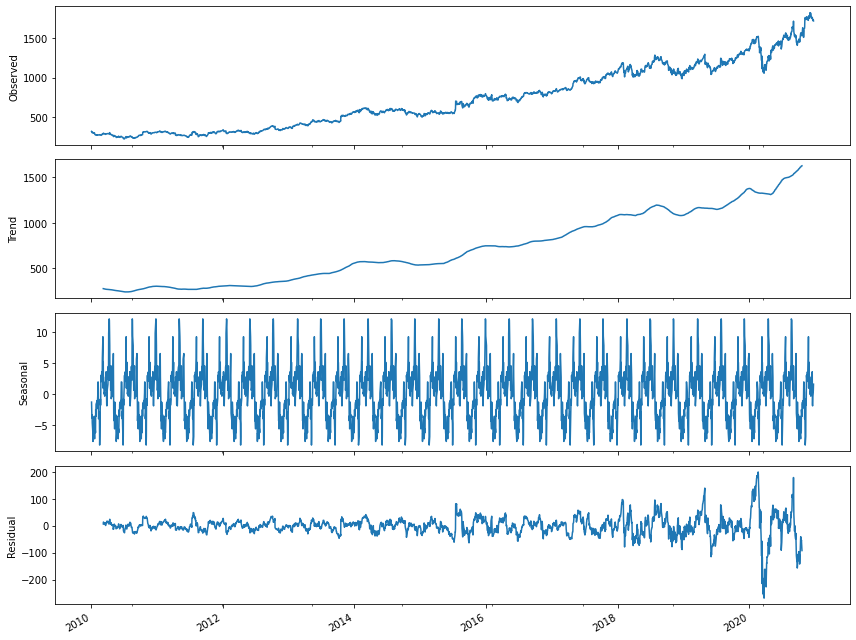

In [8]:
rcParams['figure.figsize'] = 12, 9
sm.tsa.seasonal_decompose(data.adj_close,freq=90).plot()
plt.show()

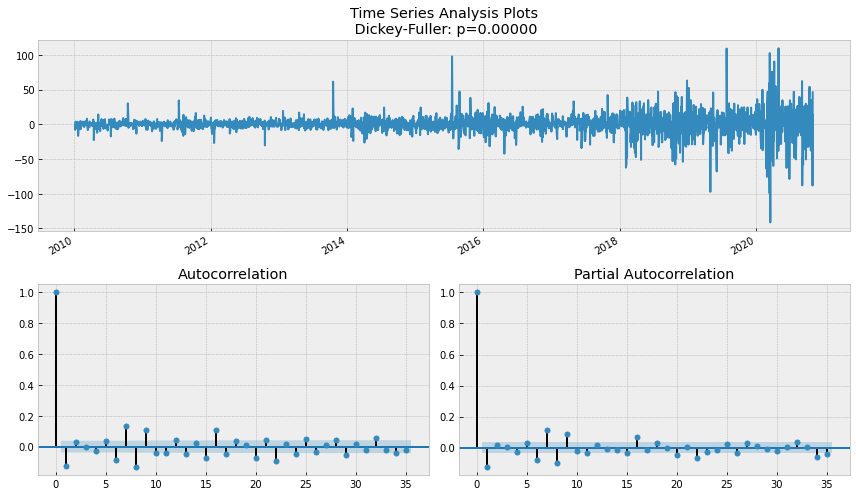

In [ ]:
tsplot(data.adj_close.diff()[1:])

# Train test split

In [ ]:
Train = data.adj_close[:1000]
Test = data.adj_close[1000:1500]

# Econometric approach

In [ ]:
model=sm.tsa.statespace.SARIMAX(Train, order=(10,1,10),trent='ct').fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:              adj_close   No. Observations:                 1000
Model:             SARIMAX(10, 1, 10)   Log Likelihood               -3053.884
Date:                Fri, 30 Oct 2020   AIC                           6149.769
Time:                        15:40:56   BIC                           6252.811
Sample:                             0   HQIC                          6188.934
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3425      0.263      1.304      0.192      -0.172       0.857
ar.L2          0.2127      0.256      0.830      0.407      -0.290       0.715
ar.L3         -0.5016      0.231     -2.168      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


10 steps prediction is:
              actual  arima_model
2013-12-23  559.2764   552.644814
2013-12-24  557.6414   552.086947
2013-12-26  560.4601   551.369599
2013-12-27  560.9315   551.009115
2013-12-30  556.4477   551.865647
2013-12-31  562.0901   552.422907
2014-01-02  558.2834   551.995951
2014-01-03  554.2108   551.564764
2014-01-06  560.3899   551.664482
2014-01-07  571.1932   552.291681


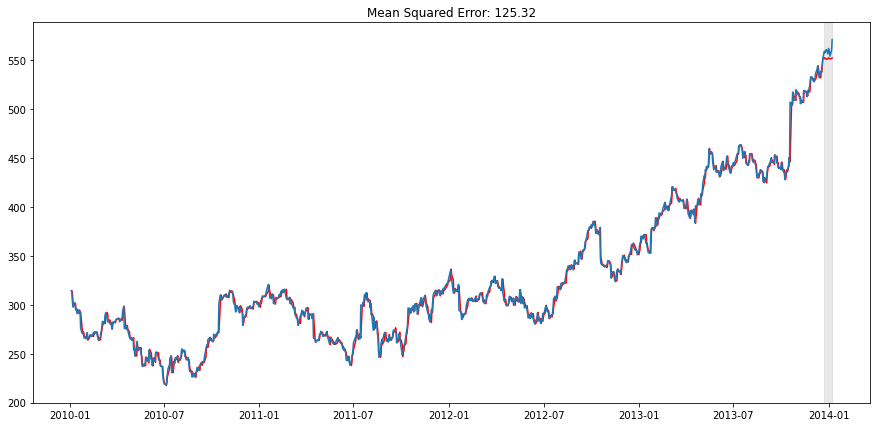

In [ ]:
n_steps = 10
plotSARIMA(data.adj_close[:1000+n_steps],model,n_steps)

# LSTM

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(Train.values.reshape(len(Train),1))

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len(Train)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)

SyntaxError: ignored

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1]))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

TypeError: ignored

# Regression models

In [ ]:
def make_features(df,window,lag):
  """
      Add features:

      1. Moving average/
      2. 

  """
  df_new = pd.DataFrame()
  df_new['adj_close'] = df['adj_close'].copy()
  df_new['return_1'] = np.log(df_new['adj_close']).diff()
  for i in window:
    df_new[f'mavg_{i}'] = data.adj_close.rolling(i).mean()
    df_new[f'ewm_{i}'] =  data.adj_close.shift(1).ewm(span=i).mean()

  for i in range(1,lag+1):
    df_new[f"lag_{i}"] = data.adj_close.shift(i)
  return df_new


In [ ]:
new_data = make_features(data,[7,30,90],10)

In [ ]:
new_data.head(10)

,adj_close,return_1,mavg_7,ewm_7,mavg_30,ewm_30,mavg_90,ewm_90,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
2010-01-04,314.3454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,312.9611,-0.004413,NaN,314.345400,NaN,314.345400,NaN,314.345400,314.3454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,305.0717,-0.025532,NaN,313.554371,NaN,313.630178,NaN,313.645559,312.9611,314.3454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,297.9698,-0.023555,NaN,309.886189,NaN,310.585122,NaN,310.723864,305.0717,312.9611,314.3454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,301.9421,0.013243,NaN,305.528195,NaN,307.109141,NaN,307.428285,297.9698,305.0717,312.9611,314.3454,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,301.4857,-0.001513,NaN,304.352728,NaN,305.933514,NaN,306.281747,301.9421,297.9698,305.0717,312.9611,314.3454,NaN,NaN,NaN,NaN,NaN
2010-01-12,296.1542,-0.017842,304.275714,303.480783,NaN,305.063369,NaN,305.437347,301.4857,301.9421,297.9698,305.0717,312.9611,314.3454,NaN,NaN,NaN,NaN
2010-01-13,294.4540,-0.005757,301.434086,301.366979,NaN,303.522470,NaN,304.021154,296.1542,301.4857,301.9421,297.9698,305.0717,312.9611,314.3454,NaN,NaN,NaN
2010-01-14,295.8382,0.004690,298.987957,299.446466,NaN,302.107463,NaN,302.730203,294.4540,296.1542,301.4857,301.9421,297.9698,305.0717,312.9611,314.3454,NaN,NaN
2010-01-15,290.8980,-0.016840,296.963143,298.471170,NaN,301.211254,NaN,301.894612,295.8382,294.4540,296.1542,301.4857,301.9421,297.9698,305.0717,312.9611,314.3454,NaN
